## Make list of train & val - image & label paths


In [1]:
import os
import glob

In [2]:
base_dir = "/mnt/sda/deep_learning/CSE527_FinalProject-master/images"
assert(os.path.isdir(base_dir))

In [3]:
folder_maps ={
    "train": {
        "images": "train",
        "labels": "label",
    },
    "val": {
        "images": "test",
        "labels": "test_label"
    }
}

In [4]:
folder_dicts = {}
for mode,dct in folder_maps.items():
    tmp = {}
    for key, val in dct.items():
        tmp[key] = os.path.join(base_dir, val)
        try:
            assert(os.path.isdir(tmp[key]))
        except:
            print("check the path given for %s in folder_dict"%key)
    folder_dicts[mode] = tmp

In [5]:
paths_dicts = {}
for mode,dct in folder_dicts.items():
    tmp = {}
    for key,val in dct.items():
        tmp[key] = sorted(glob.glob(val + "/*.tif"))
    paths_dicts[mode] = tmp

for mode,dct in paths_dicts.items():
    assert(len(dct["images"]) == len(dct["labels"]))
    print("Number of examples in %s dataset: "%mode, len(dct["images"]))

Number of examples in train dataset:  3940
Number of examples in val dataset:  860


In [6]:
class PathsDictMaker:
    def __init__(self, folder_maps, base_folder=""):
        if base_folder:
            assert(os.path.isdir(base_folder))
            self._make_folder_dicts(folder_maps, base_folder) 
    
    def _make_folder_dicts(self, folder_maps, base_folder):
        self._folder_dicts = {}
        for mode,dct in folder_maps.items():
            tmp = {}
            for key, val in dct.items():
                tmp[key] = os.path.join(base_folder, val)
                try:
                    assert(os.path.isdir(tmp[key]))
                except:
                    print("check the path given for %s in folder_maps"%key)
            self._folder_dicts[mode] = tmp
    
    def make_paths_dicts(self, file_extension=".tif"):
        paths_dicts = {}
        for mode,dct in self._folder_dicts.items():
            tmp = {}
            for key,val in dct.items():
                tmp[key] = sorted(glob.glob(val + "/*" + file_extension))
            paths_dicts[mode] = tmp
        for mode,dct in paths_dicts.items():
            assert(len(dct["images"]) == len(dct["labels"]))
            print("Number of examples in %s dataset: "%mode, len(dct["images"]))
        return paths_dicts

In [7]:
paths_dict = PathsDictMaker(folder_maps, base_folder=base_dir).make_paths_dicts()

Number of examples in train dataset:  3940
Number of examples in val dataset:  860


## Make a tf.data.Dataset and preprocess/augment the images

In [8]:
import tensorflow as tf
tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE
from PIL import Image
#%matplotlib widget ## doesn't work with multiple virtual environments
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torchvision.transforms.functional as TF

### convert dicts to tf.data.Dataset and check if the images and masks taken from the dataset are matching

In [9]:
datasets = {}
for mode,dct in paths_dicts.items():
    datasets[mode] = tf.data.Dataset.from_tensor_slices(dct)
print(datasets)

{'train': <DatasetV1Adapter shapes: {images: (), labels: ()}, types: {images: tf.string, labels: tf.string}>, 'val': <DatasetV1Adapter shapes: {images: (), labels: ()}, types: {images: tf.string, labels: tf.string}>}


In [10]:
for next_element in datasets["train"].shuffle(buffer_size=4000).take(1):
    print(next_element["images"].numpy(), next_element["labels"])
    print(type(next_element["images"].numpy()))

b'/mnt/sda/deep_learning/CSE527_FinalProject-master/images/train/1694.tif' tf.Tensor(b'/mnt/sda/deep_learning/CSE527_FinalProject-master/images/label/1694.tif', shape=(), dtype=string)
<class 'bytes'>


### check if the loading and reshape works

In [11]:
def load_img(datapoint, size, pil=False):
    img_pil = Image.open(datapoint["images"].numpy()).resize(size)
    mask_pil = Image.open(datapoint["labels"].numpy()).resize(size)
    if pil:
        return img_pil, mask_pil
    else:
        return pil_to_np(img_pil, mask_pil)

def pil_to_np(img_pil, mask_pil):
    img  = np.array(img_pil).astype("float32")/255.
    mask = np.array(mask_pil)
    return np.expand_dims(img, axis=-1), mask

def load_random_image(ds, size, pil=False):
    for next_element in ds.shuffle(buffer_size=4000).take(1):
        img, mask = load_img(next_element, size, pil)
    return img, mask

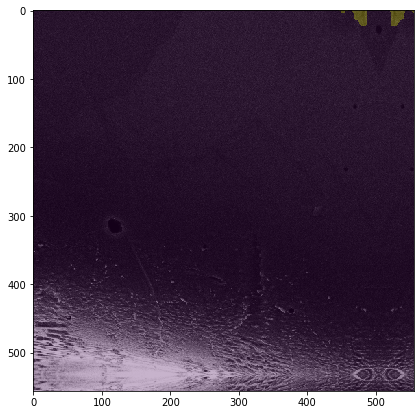

In [12]:
img, mask = load_random_image(datasets["train"], (556,556))
plt.figure(figsize=(7,7))
plt.imshow(np.squeeze(img, axis=-1), cmap="gray")
plt.imshow(mask, alpha=0.3)

### check if data augmentation works

#### brightness

In [13]:
img, mask = load_random_image(datasets["train"], (556,556))
@interact
def adjust_brightness(delta=(-0.15,0.16,0.05)):
    img_adj = tf.image.adjust_brightness(img, delta=delta)
    print(img_adj.shape)
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(np.squeeze(img, axis=-1), cmap="gray", vmin=0, vmax=1)
    plt.subplot(122)
    plt.imshow(np.squeeze(img_adj, axis=-1), cmap="gray", vmin=0, vmax=1)
max_delta = 0.15

interactive(children=(FloatSlider(value=2.7755575615628914e-17, description='delta', max=0.16, min=-0.15, step…

#### contrast

In [14]:
img, mask = load_random_image(datasets["train"], (556,556))
@interact
def adjust_contrast(contrast_factor=(0.5,1.5,0.05)):
    img_adj = tf.image.adjust_contrast(img, contrast_factor=contrast_factor)
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(np.squeeze(img, axis=-1), cmap="gray", vmin=0, vmax=1)
    plt.subplot(122)
    plt.imshow(np.squeeze(img_adj, axis=-1), cmap="gray", vmin=0, vmax=1)
lower = 0.15
upper = 1.5

interactive(children=(FloatSlider(value=1.0, description='contrast_factor', max=1.5, min=0.5, step=0.05), Outp…

#### affine transform - with keras

In [15]:
img, mask = load_random_image(datasets["train"], (556,556))
@interact
def transform_affine(theta=(-30,30),tx=(-50,50),shear=(-6,6),zx=(0.8,1.21),fill_mode=['constant', 'reflect', 'nearest'],order=(-1,1)):
    img_adj = tf.keras.preprocessing.image.apply_affine_transform(img, theta=theta,tx=tx,ty=tx,shear=shear,zx=zx,
                                                                  zy=zx,fill_mode=fill_mode,order=order)
    mask_adj = tf.keras.preprocessing.image.apply_affine_transform(np.expand_dims(mask, axis=-1), theta=theta,tx=tx,ty=tx,shear=shear,zx=zx,
                                                                  zy=zx,fill_mode=fill_mode,order=0)
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(np.squeeze(img, axis=-1), cmap="gray", vmin=0, vmax=1)
    plt.imshow(mask, alpha=0.3)
    plt.subplot(122)
    plt.imshow(np.squeeze(img_adj, axis=-1), cmap="gray", vmin=0, vmax=1)
    plt.imshow(np.squeeze(mask_adj, axis=-1), alpha=0.3)

interactive(children=(IntSlider(value=0, description='theta', max=30, min=-30), IntSlider(value=0, description…

In [16]:
theta=30
tx=50
shear=6
zx=0.8
fill_mode='constant'
order=0

In [17]:
%%timeit
img_adj = tf.keras.preprocessing.image.apply_affine_transform(img, theta=theta,tx=tx,ty=tx,shear=shear,zx=zx,
                                                                  zy=zx,fill_mode=fill_mode,order=order)
mask_adj = tf.keras.preprocessing.image.apply_affine_transform(np.expand_dims(mask, axis=-1), theta=theta,tx=tx,ty=tx,shear=shear,zx=zx,
                                                                  zy=zx,fill_mode=fill_mode,order=order)

11.1 ms ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
img_plus_mask = np.concatenate((img, np.expand_dims(mask, axis=-1)), axis=2)
img_adj = tf.keras.preprocessing.image.apply_affine_transform(img_plus_mask, theta=theta,tx=tx,ty=tx,shear=shear,zx=zx,
                                                                  zy=zx,fill_mode=fill_mode,order=order)

11.4 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**NOTE**: The keras' version of affine_transform is very slow compared to the one from torchvision!

#### affine transform - with torchvision

In [19]:
img, mask = load_random_image(datasets["train"], (556,556), pil=True)
@interact
def affine_transform(angle=(-30,30,1), translate=(-100,100,1), scale=(0.9,1.1,0.05), shear=(-6,6,0.05)):
    img_trf = TF.affine(img, angle, (translate, translate), scale, shear, resample=0, fillcolor=None)
    mask_trf = TF.affine(mask, angle, (translate, translate), scale, shear, resample=0, fillcolor=None)
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.imshow(mask, alpha=0.3)
    plt.subplot(122)
    plt.imshow(img_trf, cmap="gray", vmin=0, vmax=255)
    plt.imshow(mask_trf, alpha=0.3)

interactive(children=(IntSlider(value=0, description='angle', max=30, min=-30), IntSlider(value=0, description…

In [20]:
angle=30
translate = 50
scale = 1.5
shear = 6

In [21]:
%%timeit
img_trf = TF.affine(img, angle, (translate, translate), scale, shear, resample=0, fillcolor=None)
mask_trf = TF.affine(mask, angle, (translate, translate), scale, shear, resample=0, fillcolor=None)

618 µs ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### elastic transforms

Elastic transform code from https://gist.github.com/erniejunior/601cdf56d2b424757de5

In [22]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
def elastic_transform_git_mod(image, label, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    distored_label = map_coordinates(label, indices, order=0, mode='reflect')
    return distored_image.reshape(shape), distored_label.reshape(shape)

In [23]:
img, mask = load_random_image(datasets["train"], (556,556))
@interact
def elastic_transform(alpha=(0,1400,1), sigma=(5.75,7,0.01)):
    img_trf, mask_trf = elastic_transform_git_mod(img, mask[..., None], alpha, sigma)
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img[...,0], cmap="gray")
    plt.imshow(mask, alpha=0.3)
    plt.subplot(122)
    plt.imshow(img_trf[...,0], cmap="gray")
    plt.imshow(mask_trf[...,0], alpha=0.3)

interactive(children=(IntSlider(value=700, description='alpha', max=1400), FloatSlider(value=6.37, description…

### data input pipeline class

In [24]:
    def _extract_image(self, datapoint, size):
        img_pil = tf.py_function(self._read_images_pil, [datapoint["images"], size], tf.uint8)
        mask_pil = tf.py_function(self._read_images_pil, [datapoint["labels"], size], tf.uint8)
        return img_pil, mask_pil
    
    def _read_images_pil(self, filename, size):
        image = Image.open(filename.decode("utf-8")).resize(size)
        image = np.asarray(image)
        return image


In [70]:
class ImageInputPipeline:
    def __init__(self, folder_maps, file_extension=".tif", base_folder=""):
        paths_dict_maker = PathsDictMaker(folder_maps, base_folder)
        paths_dicts = paths_dict_maker.make_paths_dicts(file_extension)
        self._train_paths_ds = tf.data.Dataset.from_tensor_slices(paths_dicts["train"])
        self._val_paths_ds = tf.data.Dataset.from_tensor_slices(paths_dicts["val"])
        
    def _extract_image(self, image, label):
        print("exe")
        augment=False
        size=(556,556)
        img_pil = Image.open(image.decode('utf-8')).resize(size)
        mask_pil = Image.open(label.decode('utf-8')).resize(size)
        if augment:
            return self._augment_image(img_pil, mask_pil)
        else:
            return self._pil_to_np(img, mask)
    
    def _augment_image(self, image_pil, mask_pil):
        ## start with affine transform since it works on pil images
        angle = random.randint(-30, 30)
        translate =(random.randint(-50, 50), random.randint(-50, 50))
        scale = 0.9 + random.random()*0.2
        shear = random.randint(-6, 6)
        img_trf = TF.affine(image_pil, angle, translate, scale, shear, resample=0, fillcolor=None)
        mask_trf = TF.affine(mask_pil, angle, translate, scale, shear, resample=0, fillcolor=None)
        ## convert images to np
        img_trf, mask_trf = self._pil_to_np(img_trf, mask_trf)
        ## perform elastic transforms - adds channel dimension to mask_trf
        alpha = random.randint(0,700)
        sigma = 5.75 + random.random()*1.25
        img_trf, mask_trf = elastic_transform_git_mod(img_trf, mask_trf[..., None], alpha, sigma)
        ## brightness adjustments - converts img_trf to tensor
        img_trf = tf.image.random_brightness(img_trf, max_delta=0.15)
        ## contrast adjustments
        img_trf = tf.image.random_contrast(img_trf, lower = 0.15, upper = 1.5)
        return img_trf, mask_trf
        
    def _pil_to_np(self, img_pil, mask_pil):
        img  = np.array(img_pil).astype("float32")/255.
        mask = np.array(mask_pil)
        return np.expand_dims(img, axis=-1), mask
    
    def _preprocess(self, datapoint, augment, size):
        img, mask = tf.py_function(self._extract_image, [datapoint["images"], datapoint["labels"]], [tf.float32, tf.int8])
        return img, mask
        
    def train_input_fn(self, size, batch_size):
        self._train_paths_ds.map(lambda datapoint: self._preprocess(datapoint, augment=True, size=size), num_parallel_calls=AUTOTUNE)
        return self._train_paths_ds.batch(batch_size).repeat().shuffle(4000).prefetch(AUTOTUNE)

In [71]:
input_pipeline = ImageInputPipeline(folder_maps, ".tif", base_dir)

Number of examples in train dataset:  3940
Number of examples in val dataset:  860


In [72]:
for image, label in input_pipeline.train_input_fn(size=(556,556), batch_size=4).take(1):
    print("Image shape: ", image)
    print("Label: ", label)

Image shape:  images
Label:  labels
